In [6]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
!pip install xgboost

In [2]:
events = Events("CheatedRecoFile_1.root")
# Count unique events
unique_events = np.unique(events.event_number)
num_unique_events = len(unique_events)

print(f"Number of unique events: {num_unique_events}")

Number of unique events: 9439


In [3]:
''' The Features ''' 

# from before 
def correlation(events, event_idx):
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx] 

    # Check if there are valid hits
    if len(w_hits) == len(x_hits) and len(w_hits) > 15: # talk about advantages and disadvantages of results with a threshold 
        if np.std(x_hits) == 0 or np.std(w_hits) == 0:
            return None  # No valid correlation if there's no variation in data
        
        correlation = np.corrcoef(x_hits, w_hits)[0, 1]
        
        # Fit line using w_hits for x and calculate predicted y-values
        line_fit = np.polyfit(w_hits, x_hits, 1)
        line_y_pred = np.polyval(line_fit, w_hits)
        
        # Calculate line error between predicted and actual x_hits
        line_error = np.mean((x_hits - line_y_pred) ** 2)
        
        # Normalize scores
        correlation_score = abs(correlation) if not np.isnan(correlation) else 0
        error_score = max(0, 1 - line_error / 20) if line_error < 20 else 0
        
        # Weighted score
        line_score = (correlation_score * 0.7) + (error_score * 0.3)
        
        return (line_score * 100)  # Return the score and category

    else:
        return None

# from before 

def noise(events, event_idx, eps=2, min_samples=5):
    # Extract hit positions (no PDG filtering, just use reco hits)
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx]

    # Check if there are valid hits
    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
        # Combine the coordinates for clustering
        hits_coordinates = np.column_stack((w_hits, x_hits))

        # Apply DBSCAN clustering
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(hits_coordinates)
        labels = db.labels_

        # Count noise points (labeled as -1)
        n_noise = np.sum(labels == -1)

        # Count clusters (unique labels excluding -1)
        unique_clusters = set(labels) - {-1}
        n_clusters = len(unique_clusters)

        return n_noise + n_clusters
    else:
        return None
def rms(events, event_idx):
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]

    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
        slope, intercept = np.polyfit(w_hits, x_hits, 1)
        
        actual = x_hits
        predicted = slope * w_hits + intercept
        
        meanSquaredError = ((predicted - actual) ** 2).mean()
        return np.sqrt(meanSquaredError)
    else: 
        return None 


import numpy as np

def angle(events, event_idx):
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx]

    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
        # Fit the best-fit line
        line_fit = np.polyfit(w_hits, x_hits, 1)
        line_slope = line_fit[0]
        line_intercept = line_fit[1]

        # Calculate residuals (distance from the line)
        line_y_pred = np.polyval(line_fit, w_hits)
        residuals = np.abs(x_hits - line_y_pred)

        # Find the index of the furthest point
        furthest_idx = np.argmax(residuals)
        furthest_point = np.array([x_hits[furthest_idx], w_hits[furthest_idx]])

        # Start of the line is at the minimum W-coordinate
        min_w = np.min(w_hits)
        start_point = np.array([line_slope * min_w + line_intercept, min_w])

        # End of the red line (best-fit line) at the maximum W-coordinate
        max_w = np.max(w_hits)
        end_of_red_line = np.array([line_slope * max_w + line_intercept, max_w])

        # Calculate the lengths of the three sides of the triangle
        red_line_length = np.linalg.norm(end_of_red_line - start_point)  # Distance between start and end of red line
        purple_line_length = np.linalg.norm(furthest_point - start_point)  # Distance between start and furthest point (purple line)
        third_line_length = np.linalg.norm(furthest_point - end_of_red_line)  # Distance between end of red line and furthest point (third line)

        # Using the cosine rule to calculate the angle between the red and purple lines
        cos_theta = (red_line_length**2 + purple_line_length**2 - third_line_length**2) / (2 * red_line_length * purple_line_length)
        angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip value to avoid out-of-bound errors
        angle_degrees = np.degrees(angle_radians)  # Convert radians to degrees
        
        return angle_degrees
    else:
        return None



def line(events, event_idx):
    w_hits = np.array(events.reco_hits_w[event_idx])
    x_hits = np.array(events.reco_hits_x_w[event_idx])

    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
    
        # Calculate differences between consecutive points
        dx = np.diff(w_hits)
        dy = np.diff(x_hits)
    
        # Compute segment lengths
        segment_lengths = np.sqrt(dx**2 + dy**2)
    
        # Total arc length (line integral)
        total_length = np.sum(segment_lengths)
    
        # Normalize by the number of points
        normalised_length = total_length / len(w_hits)

        return normalised_length
    else:
        return None 



def q4(events, event_idx):
    adcs = events.reco_adcs_w[event_idx]

    if len(adcs) > 15:

        q4_idx = len(adcs) // 4

        adcs_q4 = adcs[-q4_idx:]
    
        ratio = sum(adcs_q4) / sum(adcs)
    
    
        return ratio
    else:
       return None



def step_length(events, event_idx):
    # Find all info for the feature
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]

    # Skip events where there are fewer than 15 hits
    if len(w_hits) < 15:
        return None  # Return None to indicate that the feature should be skipped

    # Finding step length
    w_step = min([abs(w - w_vtx) for w in w_hits])
    x_step = min([abs(x - x_vtx) for x in x_hits])
    step_length = np.sqrt(w_step**2 + x_step**2)

    return step_length





def de_dx(events, event_idx, eps=2, min_samples=5, radius=5):
    adc_sum_inside_circle = 0
    hits_within_5cm = 0  # Count number of hits within 5cm

    # Get all hits for the given event
    all_x_hits = events.reco_hits_x_w[event_idx]
    all_w_hits = events.reco_hits_w[event_idx]
    all_adc_values = events.reco_adcs_w[event_idx]
    all_pdg_codes = events.mc_pdg[event_idx]

    # Skip events where there are fewer than 15 hits
    if len(all_w_hits) < 15:
        return None  # Return None to indicate that the feature should be skipped

    # Combine coordinates for clustering
    hits_coordinates = np.column_stack((all_w_hits, all_x_hits))

    # Apply DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(hits_coordinates)
    labels = db.labels_

    # Identify the core points (those labeled with a label >= 0)
    core_points = hits_coordinates[labels >= 0]

    # If there are no core points, skip the event
    if len(core_points) == 0:
        return None  # No core points to work with

    # Get the true neutrino interaction vertex
    true_vertex_x = events.neutrino_vtx_x[event_idx]
    true_vertex_w = events.neutrino_vtx_w[event_idx]

    # Find the nearest core point to the true neutrino vertex
    distances = np.sqrt((core_points[:, 0] - true_vertex_w) ** 2 + (core_points[:, 1] - true_vertex_x) ** 2)
    nearest_core_point_idx = np.argmin(distances)
    nearest_core_point = core_points[nearest_core_point_idx]

    # Compute distances and sum ADC values inside a 5cm radius
    for i in range(len(all_w_hits)):
        distance = np.sqrt((all_w_hits[i] - nearest_core_point[0]) ** 2 + (all_x_hits[i] - nearest_core_point[1]) ** 2)
        if distance <= radius:
            hits_within_5cm += 1
            adc_sum_inside_circle += all_adc_values[i]

    # Apply filtering: Skip events with fewer than 3 hits within 5cm
    if hits_within_5cm < 3:
        return None  # Not enough hits

    # Divide the ADC sum by 5 to get the dE/dx feature (in ADC/5)
    de_dx = adc_sum_inside_circle / 5

    return de_dx

def hit_count(events, event_idx, min_hits=15):
    """ Hit_count is to help candidate_lepton it increased the accuracy by around 1.5% """
    # Get all hits for the given event
    all_w_hits = events.reco_hits_w[event_idx]  # Wire plane hits
    all_x_hits = events.reco_hits_x_w[event_idx]  # X-plane hits
    
    # Count total number of hits
    num_hits = len(all_w_hits)  # Assuming same length for both planes

    # Apply filtering: Skip events with fewer than `min_hits`
    if num_hits < min_hits:
        return None  # Not enough hits
    
    return num_hits



def calculate_features(events, indices):
    """
    Calculate all features for the given event indices.
    """
    features = {
        'correlation': [],
        'noise': [],
        'rms': [],
        'angle': [],
        'line': [],
        'q4': [],
        'step_length': [],
        'de_dx': [],
        'hit_count': [],
    }

    for event_idx in indices:
        features['correlation'].append(correlation(events, event_idx))
        features['noise'].append(noise(events, event_idx))
        features['rms'].append(rms(events, event_idx))
        features['angle'].append(angle(events, event_idx))
        features['line'].append(line(events, event_idx))
        features['q4'].append(q4(events, event_idx))
        features['step_length'].append(step_length(events, event_idx))
        features['de_dx'].append(de_dx(events, event_idx))
        features['hit_count'].append(hit_count(events, event_idx))
    
    return features

In [4]:
# Define particle sets for easier reference
MUON_PDG_SET = {13, -13}  # Muon and anti-muon
ELECTRON_PDG_SET = {11, -11}  # Electron and positron
PHOTON_PDG_SET = {22, -22}  # Photon PDG codes
SHOWER_PDG_SET = {11, -11, 22, -22}  # All shower-like particles

def group_by_event(events):
    """
    Groups indices by event number.
    Returns a dictionary where keys are event numbers and values are lists of indices.
    """
    event_dict = {}
    
    for i in range(len(events.event_number)):
        event_num = events.event_number[i]
        
        if event_num not in event_dict:
            event_dict[event_num] = []
            
        event_dict[event_num].append(i)
        
    return event_dict

def is_primary_particle(events, idx, max_distance=10):
    """
    Determines if a particle starts near the neutrino vertex (primary particle).
    """
    # Get vertex position
    vertex_w = events.neutrino_vtx_w[idx]
    vertex_x = events.neutrino_vtx_x[idx]
    
    # Get first hit position (assuming hits are ordered)
    hit_w = events.reco_hits_w[idx][0] if len(events.reco_hits_w[idx]) > 0 else None
    hit_x = events.reco_hits_x_w[idx][0] if len(events.reco_hits_x_w[idx]) > 0 else None
    
    if hit_w is None or hit_x is None:
        return False
    
    # Calculate distance to vertex
    distance_to_vertex = np.sqrt((hit_w - vertex_w)**2 + (hit_x - vertex_x)**2)
    
    return distance_to_vertex < max_distance

def identify_event_type(events, event_indices):
    """
    Identifies event type by examining all particles in an event.
    Returns: 
        - 0 for CCnumu (muon found)
        - 2 for CCnue (primary electron found)
        - 1 for NC (neither muon nor primary electron found)
    """
    found_muon = False
    found_primary_electron = False
    
    for idx in event_indices:
        pdg_code = events.mc_pdg[idx]
        
        # Check for muon
        if pdg_code in MUON_PDG_SET:
            found_muon = True
            break  # Muon has highest priority, so we can stop looking
            
        # Check for primary electron
        elif pdg_code in ELECTRON_PDG_SET:
            if is_primary_particle(events, idx):
                found_primary_electron = True
                # Don't break here because we might still find a muon
    
    # Classify based on hierarchy
    if found_muon:
        return 0  # CCnumu
    elif found_primary_electron:
        return 2  # CCnue
    else:
        return 1  # NC

def process_all_events(events):
    """
    Process all events and determine their type.
    Returns:
        - event_types: Dictionary of event number to type (0, 1, or 2)
        - event_indices: Dictionary of event number to list of indices
    """
    event_groups = group_by_event(events)
    event_types = {}
    
    for event_num, indices in event_groups.items():
        event_type = identify_event_type(events, indices)
        event_types[event_num] = event_type
        
    return event_types, event_groups

def extract_features_for_events(events):
    """
    Extract all event numbers, classify them, and extract features.
    Returns feature matrix and labels.
    """
    # Get event classifications and groupings
    event_types, event_groups = process_all_events(events)
    
    features = []
    labels = []
    
    for event_num, event_type in event_types.items():
        # Get indices for this event
        indices = event_groups[event_num]
        
        # Calculate combined features for the entire event
        event_features = calculate_event_features(events, indices)
        
        if event_features is not None:
            features.append(event_features)
            labels.append(event_type)
    
    return np.array(features), np.array(labels)

def calculate_event_features(events, indices):
    """
    Calculate features for an entire event using all particles.
    """
    # We'll calculate the features for all particles and then combine them
    all_features = {
        'correlation': [],
        'noise': [],
        'rms': [],
        'angle': [],
        'line': [],
        'q4': [],
        'step_length': [],
        'de_dx': [],
        'hit_count': [],
    }
    
    # Extract features for each particle
    for idx in indices:
        particle_features = calculate_features(events, [idx])
        
        for feature_name, values in particle_features.items():
            if values[0] is not None:  # Only add non-None values
                all_features[feature_name].append(values[0])
    
    # Check if we have enough data to create features
    if not all(len(feature_list) > 0 for feature_list in all_features.values()):
        return None
    
    # Create combined features - using different aggregation methods for different features
    combined_features = [
        
        # Correlation
        np.mean(all_features['correlation']), np.median(all_features['correlation']),
        np.std(all_features['correlation']), np.max(all_features['correlation']),
        np.sum(all_features['correlation']), np.min(all_features['correlation']),
    
        # Noise
        np.mean(all_features['noise']), np.median(all_features['noise']),
        np.std(all_features['noise']), np.max(all_features['noise']),
        np.sum(all_features['noise']),
    
        # RMS
        np.mean(all_features['rms']), np.median(all_features['rms']),
        np.std(all_features['rms']), np.max(all_features['rms']),
        np.sum(all_features['rms']),
    
        # Angle
        np.mean(all_features['angle']), np.median(all_features['angle']),
        np.std(all_features['angle']), np.max(all_features['angle']),
        np.sum(all_features['angle']),
    
        # Line
        np.mean(all_features['line']), np.median(all_features['line']),
        np.std(all_features['line']), np.max(all_features['line']),
        np.sum(all_features['line']),
    
        # Q4
        np.mean(all_features['q4']), np.median(all_features['q4']),
        np.std(all_features['q4']), np.max(all_features['q4']),
        np.sum(all_features['q4']),
    
        # Step Length
        np.mean(all_features['step_length']), np.median(all_features['step_length']),
        np.std(all_features['step_length']), np.max(all_features['step_length']),
        np.sum(all_features['step_length']),
    
        # dE/dx
        np.mean(all_features['de_dx']), np.median(all_features['de_dx']),
        np.std(all_features['de_dx']), np.max(all_features['de_dx']),
        np.sum(all_features['de_dx']),
    
        # Hit Count
        np.mean(all_features['hit_count']), np.median(all_features['hit_count']),
        np.std(all_features['hit_count']), np.max(all_features['hit_count']),
        np.sum(all_features['hit_count']),
    ]

    
    return combined_features

# You can use your existing calculate_features function here

# Main execution
def run_improved_classification(events):
    """
    Run the improved classification method on all events.
    """
    print("Processing events using improved classification method...")
    
    # Extract features and labels
    X, y = extract_features_for_events(events)
    
    print(f"Processed {len(X)} events")
    print(f"CCnumu events: {np.sum(y == 0)}")
    print(f"NC events: {np.sum(y == 1)}")
    print(f"CCnue events: {np.sum(y == 2)}")
    
    return X, y

In [7]:
# Run the improved event classification
x_test, y_test = run_improved_classification(events)

Processing events using improved classification method...
Processed 8574 events
CCnumu events: 4006
NC events: 2373
CCnue events: 2195


In [7]:
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Load the saved model
bdt_loaded = joblib.load("bdt_model_all_noCL.pkl")
print("Model loaded successfully!")

# Make predictions on the test set
y_pred = bdt_loaded.predict(x_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Model loaded successfully!
Accuracy: 72.84%


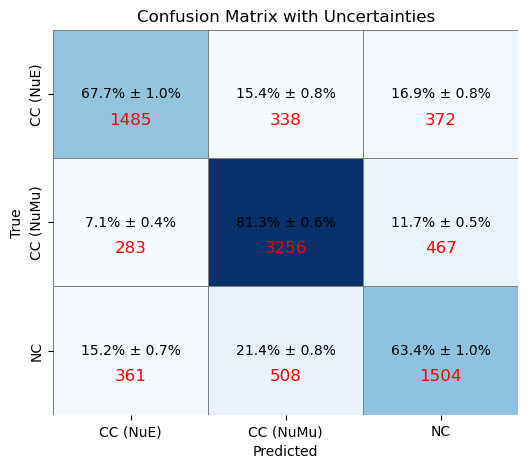

In [8]:
import pandas as pd
import seaborn as sns

# Step 6: Generate confusion matrix
labels = ["CC (NuE)", "CC (NuMu)", "NC"]
conf_matrix = confusion_matrix(y_test, y_pred, labels=[2, 0, 1])  # Muon (0), NC (1: Photon + Other), Electron (2)
    
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
    
# Compute efficiencies in percentage
bin_efficiencies = (conf_matrix / conf_matrix.sum(axis=1, keepdims=True)) * 100  # Convert to percentage
    
# Compute binomial uncertainties in percentage
uncertainties = np.sqrt((bin_efficiencies / 100) * (1 - (bin_efficiencies / 100)) / conf_matrix.sum(axis=1, keepdims=True)) * 100  
    
# Plot confusion matrix with percentages and uncertainties
plt.figure(figsize=(6, 5))
ax = sns.heatmap(df_cm, annot=False, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
    
for i in range(len(labels)):
    for j in range(len(labels)):
        total = conf_matrix[i, :].sum()  # Total instances of the actual class
        if total > 0:
            percentage = bin_efficiencies[i, j]
            uncertainty = uncertainties[i, j]
            ax.text(j + 0.5, i + 0.5, f"{percentage:.1f}% ± {uncertainty:.1f}%", ha='center', va='center', fontsize=10, color='black')

# Annotate with raw numbers in raw below the percentages and uncertainties
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j + 0.5, i + 0.7, f"{conf_matrix[i, j]}", ha='center', va='center', fontsize=12, color='red')
    
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix with Uncertainties")
plt.show()

In [8]:
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Load the saved model
bdt_loaded = joblib.load("optimized_xgb_model_whole.pkl")
print("Model loaded successfully!")

# Make predictions on the test set
y_pred = bdt_loaded.predict(x_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Model loaded successfully!
Accuracy: 73.55%


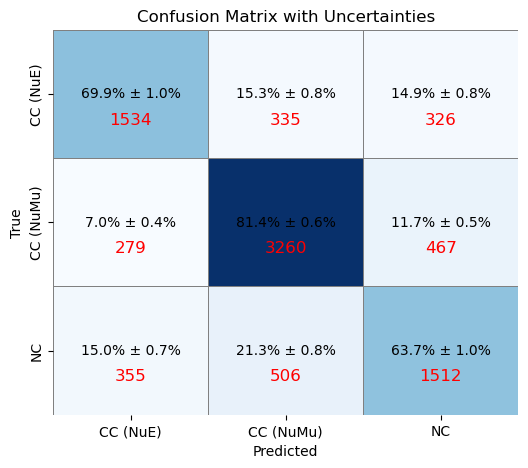

In [9]:
import pandas as pd
import seaborn as sns

# Step 6: Generate confusion matrix
labels = ["CC (NuE)", "CC (NuMu)", "NC"]
conf_matrix = confusion_matrix(y_test, y_pred, labels=[2, 0, 1])  # Muon (0), NC (1: Photon + Other), Electron (2)
    
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)
    
# Compute efficiencies in percentage
bin_efficiencies = (conf_matrix / conf_matrix.sum(axis=1, keepdims=True)) * 100  # Convert to percentage
    
# Compute binomial uncertainties in percentage
uncertainties = np.sqrt((bin_efficiencies / 100) * (1 - (bin_efficiencies / 100)) / conf_matrix.sum(axis=1, keepdims=True)) * 100  
    
# Plot confusion matrix with percentages and uncertainties
plt.figure(figsize=(6, 5))
ax = sns.heatmap(df_cm, annot=False, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
    
for i in range(len(labels)):
    for j in range(len(labels)):
        total = conf_matrix[i, :].sum()  # Total instances of the actual class
        if total > 0:
            percentage = bin_efficiencies[i, j]
            uncertainty = uncertainties[i, j]
            ax.text(j + 0.5, i + 0.5, f"{percentage:.1f}% ± {uncertainty:.1f}%", ha='center', va='center', fontsize=10, color='black')

# Annotate with raw numbers in raw below the percentages and uncertainties
for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j + 0.5, i + 0.7, f"{conf_matrix[i, j]}", ha='center', va='center', fontsize=12, color='red')
    
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix with Uncertainties")
plt.show()